<a href="https://colab.research.google.com/github/ybernaerts/varimax-gradient/blob/main/algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

## Sample rotation and loading matrix

In [2]:
L = 2 # pick latent dimension

# Generate a random LxL matrix
random_matrix = np.random.randn(L, L)

# Perform QR decomposition
U,_,Vt = np.linalg.svd(random_matrix)
R = U @ Vt
print("Orthogonal matrix:")
print(R)

# Verify orthogonality (R @ R.T should be close to the identity matrix)
identity_check = R @ R.T

print("\nVerification (R @ R.T):")
print(identity_check)

Orthogonal matrix:
[[ 0.63846001  0.769655  ]
 [-0.769655    0.63846001]]

Verification (R @ R.T):
[[ 1.00000000e+00 -1.03208201e-16]
 [-1.03208201e-16  1.00000000e+00]]


Imagine we have a loading matrix neurons by  2 latents which we want to rotate as to satisfy the varimax objective.

In [3]:
N = 10
C_init = np.random.randn(N,L)
C_rot = C_init @ R

Text(0, 0.5, 'Latent 2')

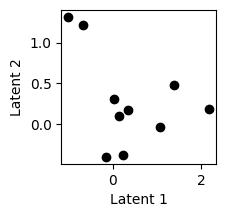

In [4]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
ax.scatter(C_rot[:,0],C_rot[:,1], color='k')
ax.set_xlabel('Latent 1')
ax.set_ylabel('Latent 2')

In [5]:
# current varimax objective per latent
1/N*np.sum(C_rot**4, axis=0)-(1/(N**2))*np.sum(C_rot**2,axis=0)**2

array([2.00159321, 0.3831719 ])

In [6]:
# final varimax objective
np.sum(
    1/N*np.sum(C_rot**4, axis=0)-(1/(N**2))*np.sum(C_rot**2,axis=0)**2
)

np.float64(2.38476510331521)

## Check Analyticity

Checking analytically derived gradient of varimax objective wrt $\mathbf{C}$.

In [7]:
def varimax(C):
  N = C.shape[0]
  return np.sum(1/N*np.sum(C**4, axis=0)-(1/(N**2))*np.sum(C**2,axis=0)**2)

In [8]:
f=lambda C: varimax(C)
def finite_difference_gradient(f, C, h=1e-5):
    grad = np.zeros_like(C)
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            E = np.zeros_like(C)
            E[i, j] = 1
            grad[i, j] = (f(C + h * E) - f(C - h * E)) / (2 * h)
    return grad

In [9]:
finite_difference_gradient(f, C_rot)

array([[ 0.05458634,  0.03731657],
       [-0.02109242,  0.71171361],
       [-0.01029582, -0.03694637],
       [ 0.13606614,  0.53950304],
       [ 0.08193363,  0.0069338 ],
       [ 3.34427132, -0.02608655],
       [-0.08731854,  0.03787533],
       [ 0.54421035, -0.03213355],
       [-0.05477286, -0.01437458],
       [-0.11575931, -0.02437889]])

In [10]:
s = 1/N*np.sum(C_rot**2, axis=0)
S = np.repeat(s[np.newaxis,:],N,axis=0)
G = 4/N*(C_rot**3-np.multiply(C_rot,S))
G

array([[ 0.05458634,  0.03731657],
       [-0.02109242,  0.71171361],
       [-0.01029582, -0.03694637],
       [ 0.13606614,  0.53950304],
       [ 0.08193363,  0.0069338 ],
       [ 3.34427132, -0.02608655],
       [-0.08731854,  0.03787533],
       [ 0.54421035, -0.03213355],
       [-0.05477286, -0.01437458],
       [-0.11575931, -0.02437889]])

$\mathbf{G}$, our analytical gradient should be the same as what our function `finite_differences()` gives

Checking analytically derived gradient of varimax w.r.t. $\mathbf{R}$, using the chain rule:

In [11]:
def varimax_R(C, R):
  N = C.shape[0]
  C_rot = C @ R
  return np.sum(1/N*np.sum(C_rot**4, axis=0)-(1/(N**2))*np.sum(C_rot**2,axis=0)**2)

In [12]:
f_R=lambda C,R: varimax_R(C,R)
def finite_difference_gradient_R(f_R, C, R, h=1e-5):
    grad = np.zeros_like(R)
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            E = np.zeros_like(R)
            E[i, j] = 1
            grad[i, j] = (f_R(C,R + h * E) - f_R(C,R - h * E)) / (2 * h)
    return grad

In [13]:
finite_difference_gradient_R(f_R,C_init,R)

array([[ 5.86586261,  0.43112137],
       [-5.53657696,  1.88088972]])

In [14]:
G_R = 4/N*C_init.T @ (C_rot**3-np.multiply(C_rot,S))
G_R

array([[ 5.86586261,  0.43112137],
       [-5.53657696,  1.88088972]])

Like before, these should also be the same.

## Projected gradient ascent.

Now we would like our eventual gradient $\mathbf{P}$, when taken a step in that direction from $\mathbf{R}$, to give as another orthogonal matrix (hence satisfying $(\mathbf{R}+\eta\mathbf{P})^\top(\mathbf{R}+\eta\mathbf{P})=\mathbf{I}$. To ensure this $\mathbf{P}$ is of a certain form, but this only sures the next $\mathbf{R}$ is orthongal up to first order. We hence do a projection to the Stiefel manifold (manifold of orthogonal matrices) with svd-decomposition of $\mathbf{R}+\mathbf{P}$. Yet, reflections also are in this manifold too, thus ensure determinant of projection to be +1 (not -1) to maximize over rotation matrices only.

In [15]:
iters = 100
lr = .1

N=10
L=2

R = np.random.randn(L,L)
C_init = np.random.randn(N,L)
U, _, Vt = np.linalg.svd(R)
R = U @ Vt
if np.linalg.det(R) < 0:
    U[:, -1] *= -1
    R = U @ Vt


Cv = C_init.copy()
Rv = R.copy()

varimaxes = []
varimaxes.append(varimax(C_init@R))

Rs = []
Rs.append(R)

for it in range(iters):
  # calculate gradient for R
  C_rot = Cv @ Rv
  s = 1/N*np.sum(C_rot**2, axis=0)
  S = np.repeat(s[np.newaxis,:],N,axis=0)
  grad = 4/N*Cv.T @ (C_rot**3-np.multiply(C_rot,S))
  P = 1/2*(grad - Rv @ grad.T @ Rv)

  # apply grad
  Rv = Rv + lr*P

  # project to manifold of rotation matrices
  U, _, Vt = np.linalg.svd(Rv)
  R_new = U @ Vt
  if np.linalg.det(R_new) < 0:
      U[:, -1] *= -1
      R_new = U @ Vt

  Rv = R_new

  varimaxes.append(varimax(C_init@Rv))
  Rs.append(Rv)

In [16]:
# check:
Rv @ Rv.T

array([[1.00000000e+00, 8.42764326e-17],
       [8.42764326e-17, 1.00000000e+00]])

In [17]:
varimax(C_init@R)

np.float64(1.2175533482427205)

In [18]:
varimax(C_init@Rv)

np.float64(1.6459114251092544)

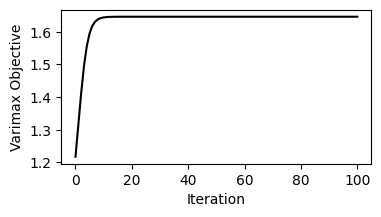

In [19]:
fig, ax = plt.subplots(1,1,figsize=(4,2))
ax.plot(varimaxes, color='k')
ax.set_xlabel('Iteration')
ax.set_ylabel('Varimax Objective')
plt.show()

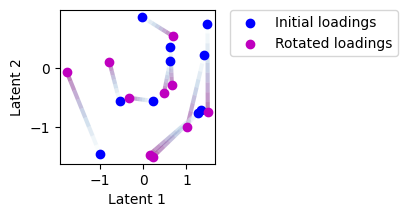

In [20]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
ax.scatter(C_init[:,0],C_init[:,1], color='b', label='Initial loadings')
ax.scatter((C_init @ Rv)[:,0],(C_init @ Rv)[:,1], color='m', label='Rotated loadings')
for n in range(N):
    x = np.linspace(C_init[n,0],(C_init @ Rv)[n,0], 10)
    y = np.linspace(C_init[n,1],(C_init @ Rv)[n,1], 10)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(0, 1)
    lc = LineCollection(segments, cmap='BuPu', norm=norm)
    lc.set_array(np.linspace(0, 1, 10))
    lc.set_linewidth(3)
    lc.set_alpha(0.5)
    lc.set_zorder(0)
    line = ax.add_collection(lc)
ax.set_xlabel('Latent 1')
ax.set_ylabel('Latent 2')
ax.legend(loc=(1.1,.7))

Finally, let us do it for multiple different rotation matrix initializations.

In [21]:
N=10 # neurons
L=2 # latents

inits=100
iters=100
lr=.1


#C_init = np.random.randn(N,L)
Cv = C_init.copy()

varimaxes = np.zeros((inits, iters+1))

for init in range(inits):
  R = np.random.randn(L,L)
  U,_,Vt = np.linalg.svd(R)
  R = U @ Vt
  if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = U @ Vt
  Rv = R.copy()
  varimaxes[init,0] = varimax(Cv@R)

  for it in range(iters):
    C_rot = Cv @ Rv
    s = 1/N*np.sum(C_rot**2, axis=0)
    S = np.repeat(s[np.newaxis,:],N,axis=0)
    grad = 4/N*Cv.T @ (C_rot**3-np.multiply(C_rot,S))
    P = 1/2*(grad - Rv @ grad.T @ Rv)

    # apply grad
    # Store the previous objective value before the update
    prev_varimax = varimaxes[init,it]
    Rv = Rv + lr*P

    # project to manifold of rotation matrices
    U, _, Vt = np.linalg.svd(Rv)
    R_new = U @ Vt
    if np.linalg.det(R_new) < 0:
        U[:, -1] *= -1
        R_new = U @ Vt

    Rv = R_new

    varimaxes[init,it+1] = varimax(Cv@Rv)

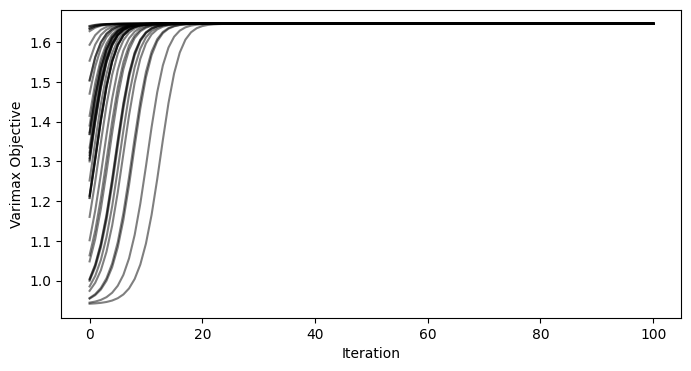

In [22]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(varimaxes[:40,:].T, color='k', alpha=0.5);
ax.set_xlabel('Iteration')
ax.set_ylabel('Varimax Objective')
plt.show()